In [1]:
#imports

import glob
import os
import random
import sys

from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import cv2
from PIL import Image
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
SAVE_PATH = "/kaggle/working/"
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

<h1>creating df

In [3]:
#creating df for data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


,dirname,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [4]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]
print(f"length of df_imgs: {len(df_imgs)}\nlength of df_masks: {len(df_masks)}")

length of df_imgs: 3929
length of df_masks: 3929


In [5]:
'''
Sort values

imgs = df_imgs['path'].sort_values(ignore_index=True)
masks = df_masks['path'].sort_values(ignore_index=True)

This method doesn't work, so insted will use sorted()
to sort only by the name if the file itself withous ending part

example of ending for mask: _mask.tif 
Which is 9 symbols
and 4 for the image: .tif

and the whole part before the name itself consists of 89 characters as well
'''

"\nSort values\n\nimgs = df_imgs['path'].sort_values(ignore_index=True)\nmasks = df_masks['path'].sort_values(ignore_index=True)\n\nThis method doesn't work, so insted will use sorted()\nto sort only by the name if the file itself withous ending part\n\nexample of ending for mask: _mask.tif \nWhich is 9 symbols\nand 4 for the image: .tif\n\nand the whole part before the name itself consists of 89 characters as well\n"

In [6]:
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[89:-4]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[89:-9]))

In [7]:
if imgs[121][:-4] == masks[121][:-9]:
    print('same')
else:
    print('different')

same


In [8]:
df = pd.DataFrame({"patient": df_imgs['dirname'].values,
                   "image_path": imgs,
                   "mask_path": masks})

# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

,patient,image_path,mask_path,diagnosis
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


diagnoses column needed for the equal split between train val and test with the same ratio of 0/1 

In [9]:
df['diagnosis'].value_counts()

0    2556
1    1373
Name: diagnosis, dtype: int64

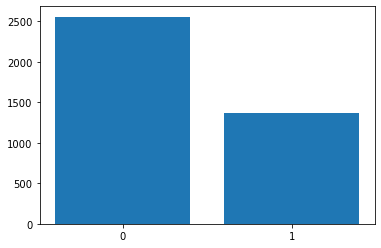

In [10]:
plt.bar(['0','1'],df['diagnosis'].value_counts());

In [11]:
#splitting data into train, val and test with the same aspect ratio of patients with and without
train_df, val_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.2)
train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.1)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df.shape, val_df.shape, test_df.shape

((2828, 4), (786, 4), (315, 4))

In [12]:
#visualize mask n images
def vis_masks_n_images(df, img_num=2):
    df = df.sample(img_num)
    df_img = df['image_path'].values
    df_mask = df['mask_path'].values
    
    fig = plt.figure(figsize=(16, 10))
    counter = 1
    
    for _, (img_p, mask_p) in enumerate(zip(df_img, df_mask)):
        img = cv2.imread(img_p)
        mask = cv2.imread(mask_p)
        
        fig.add_subplot(img_num, img_num, counter)
        plt.imshow(img)
        counter+=1
        fig.add_subplot(img_num, img_num, counter)
        plt.imshow(mask)
        counter+=1

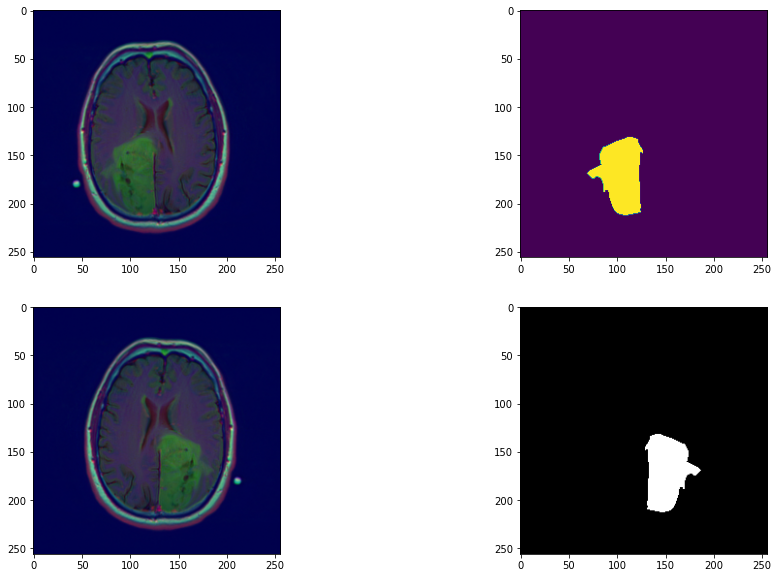

In [13]:
test = df[df['diagnosis']==1].sample(1)
t_img = test['image_path'].values
t_mask = test['mask_path'].values

transform = A.Compose([
    A.Resize(width = 256, height = 256, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])

fig = plt.figure(figsize=(16, 10))
counter=1
for _, (img_p, mask_p) in enumerate(zip(t_img, t_mask)):
        img = cv2.imread(img_p,cv2.COLOR_BGR2RGB)/255.
        mask = cv2.imread(mask_p)
        transformed = transform(image=img, mask=mask)
        transformed_image = transformed['image']
        transformed_mask = cv2.cvtColor(transformed['mask'], cv2.COLOR_BGR2GRAY)/255.
        transformed_mask[transformed_mask > 0.5] = 1
        transformed_mask[transformed_mask <= 0.5] = 0
        to_tens = ToTensorV2()
        tensors = to_tens(image=transformed_image,
                          mask=transformed_mask)
        transformed_image=tensors['image']
        transformed_mask=tensors['mask']
        #plt.imshow(  tensor_image.permute(1, 2, 0)  )
        fig.add_subplot(2, 2, 1)
        plt.imshow(transformed_image.permute(1, 2, 0))
        fig.add_subplot(2, 2, 2)
        plt.imshow(transformed_mask.permute(0, 1))
        fig.add_subplot(2, 2, 3)
        plt.imshow(img)
        fig.add_subplot(2, 2, 4)
        plt.imshow(mask)

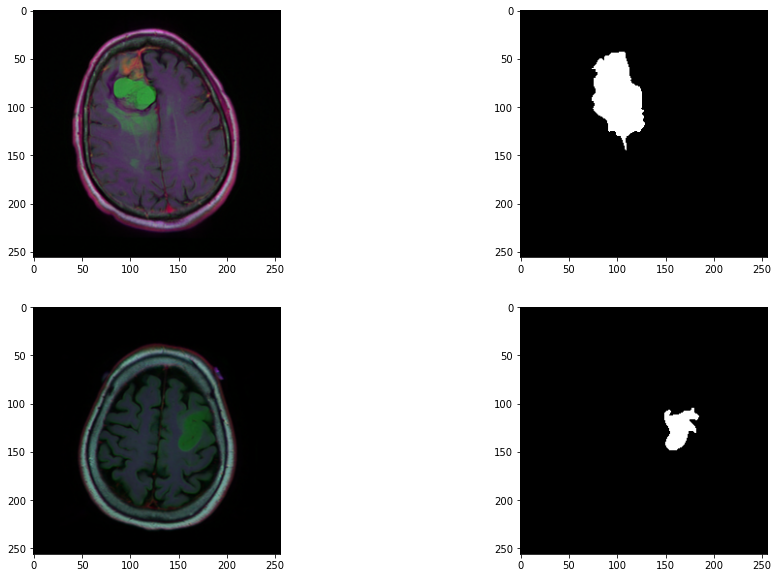

In [14]:
vis_masks_n_images(df[df["diagnosis"] == 1])

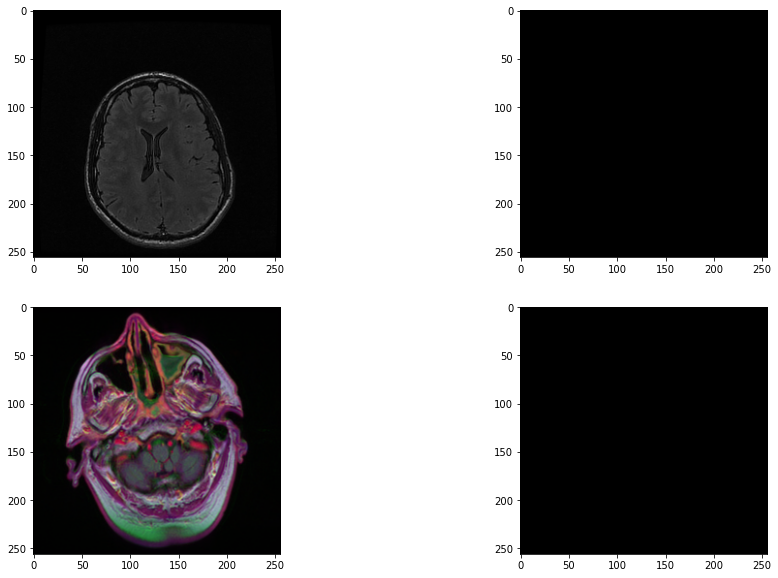

In [15]:
vis_masks_n_images(df[df["diagnosis"] == 0])

In [16]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transform):
        
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        #img = Image.open(self.df.iloc[idx, 1])
        #msk = Image.open(self.df.iloc[idx, 2])
        
        #img = Image.fromarray(cv2.imread(self.df.iloc[idx, 1], cv2.COLOR_BGR2RGB))
        #msk = Image.fromarray(cv2.imread(self.df.iloc[idx, 2], 0), 'L')
        
        img = cv2.imread(self.df.iloc[idx, 1], cv2.COLOR_BGR2RGB)/255.
        msk = cv2.imread(self.df.iloc[idx, 2])
        
        augmented = self.transform(image=img, 
                                    mask=msk)
        
        img = augmented['image']
        msk = cv2.cvtColor(augmented['mask'], cv2.COLOR_BGR2GRAY)/255.
        
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0
        
        to_tens = ToTensorV2()
        tensors = to_tens(image=img,
                          mask=msk)
        
        img = tensors['image']
        msk = tensors['mask']
        msk = msk[None, :, :]

        
        return (img, msk)

Finding mean and standard deviation of training data

In [17]:
'''
transf = A.Compose([
    A.Resize(256, 256)
])
train_dataset = BrainMriDataset(df=train_df, transform=transf)

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
'''

'\ntransf = A.Compose([\n    A.Resize(256, 256)\n])\ntrain_dataset = BrainMriDataset(df=train_df, transform=transf)\n\ntrain_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)\n'

In [18]:
#for im,d in train_dataset:
#    print(d.shape)

In [19]:
'''
[0.0877, 0.0841, 0.0930],
[0.1291, 0.1244, 0.1360]



imgs, masks = next(iter(train_dataloader))
print(f"Mean of Images: {imgs.mean(dim=[0,2,3])}\nStandard Deviation of Images: {imgs.std(dim=[0,2,3])}")
'''

'\n[0.0877, 0.0841, 0.0930],\n[0.1291, 0.1244, 0.1360]\n\n\n\nimgs, masks = next(iter(train_dataloader))\nprint(f"Mean of Images: {imgs.mean(dim=[0,2,3])}\nStandard Deviation of Images: {imgs.std(dim=[0,2,3])}")\n'

In [20]:
transform = A.Compose([
    A.Resize(width = 256, height = 256, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])

eval_transform = A.Compose([
    A.Resize(width = 256, height = 256, p=1.0)
])

In [21]:
#train
train_dataset = BrainMriDataset(df=train_df, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

#val
val_dataset = BrainMriDataset(df=val_df, transform=eval_transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#test
test_dataset = BrainMriDataset(df=test_df, transform=eval_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [22]:
for i,m in train_dataset:
    print(m.shape)
    break

torch.Size([1, 256, 256])


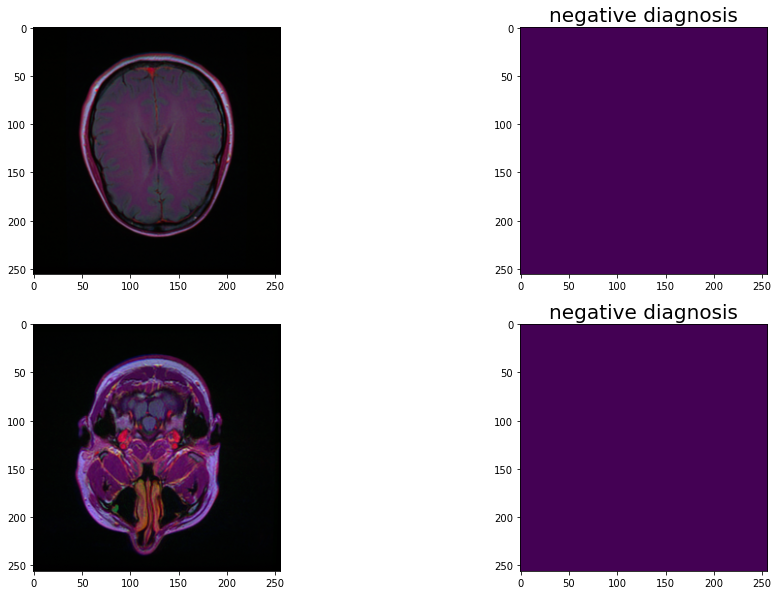

In [23]:
imgs, masks = next(iter(train_dataloader))
fig = plt.figure(figsize=(16, 10))
counter = 1
for image, mask in zip(imgs,masks):
    fig.add_subplot(2, 2, counter)
    plt.imshow(image.cpu().permute(1, 2, 0))
    counter+=1
    
    fig.add_subplot(2, 2, counter)
    plt.imshow(mask.cpu().permute(1, 2, 0))
    if torch.max(mask) == 1:
        plt.title("positive diagnosis", fontdict={"size":20})
    else:
        plt.title("negative diagnosis", fontdict={"size":20})
    counter+=1
    if counter>3:
        break

For the loss function will be using DICE coef and DICE coef with binary cross entropy for comparison. A lot of modern solutions that I was able to research were using Dice with BCE loss, so interested to try it out myself too!

In [24]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        #after calculating dice loss, we calculate BCE as well, and then add them up together
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        dice_BCE = BCE + dice_loss
        
        return dice_BCE

In [25]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, inputs, targets):
        
        assert inputs.size() == targets.size()
        
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)
        
        return dice_loss

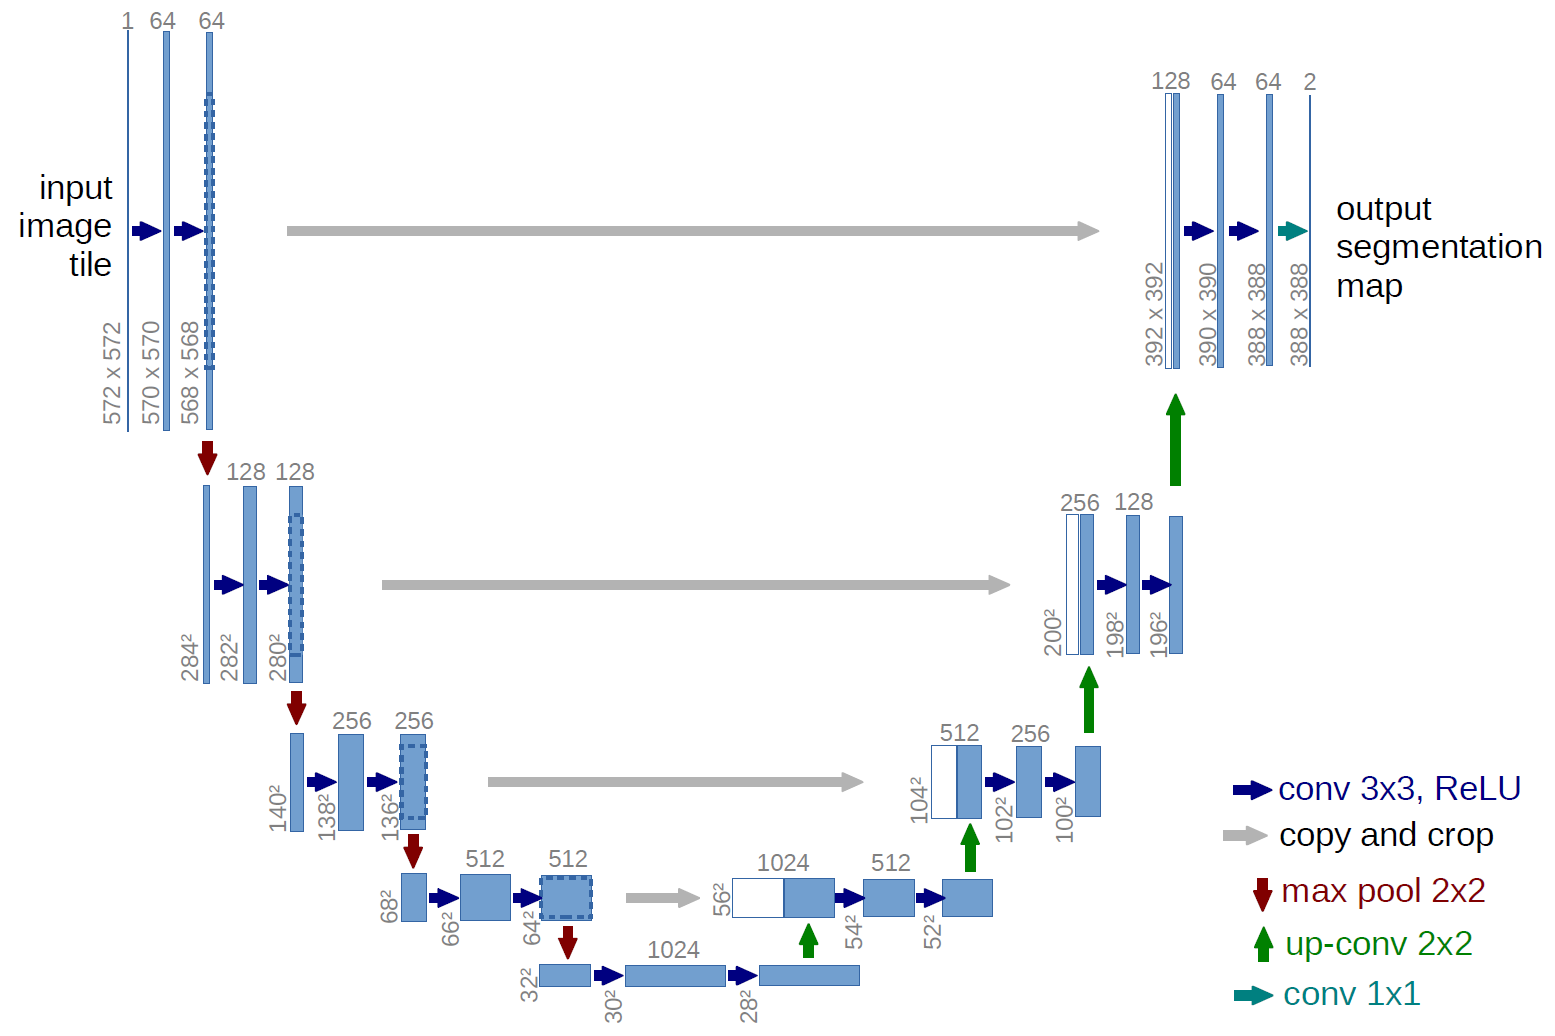

In [26]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,padding=padding,bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels,eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
    
class StackDecoder(nn.Module):
    def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackDecoder,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_tensor):
            _, channels, height, width = down_tensor.size()  
            x = F.upsample(x, size=(height, width), mode='bilinear')
            x = torch.cat([x, down_tensor], 1)  
            x = self.block(x)
            return x
        
        
class Unet256(nn.Module):
    def __init__(self,input_shape):
        super(Unet256,self).__init__()
        
        channel,height,width = input_shape
        
        self.down1 = StackEncoder(channel,64,kernel_size=(3,3))  
        self.down2 = StackEncoder(64,128,kernel_size=(3,3))  
        self.down3 = StackEncoder(128,256,kernel_size=(3,3))  
        self.down4 = StackEncoder(256,512,kernel_size=(3,3))  
        self.down5 = StackEncoder(512,1024,kernel_size=(3,3))  
        
        self.center = ConvBlock(1024,1024,kernel_size=(3,3),padding=1) 
        
        self.up5 = StackDecoder(1024,1024,512,kernel_size=(3,3))  
        self.up4 = StackDecoder(512,512,256,kernel_size=(3,3)) 
        self.up3 = StackDecoder(256,256,128,kernel_size=(3,3))
        self.up2 = StackDecoder(128,128,64,kernel_size=(3,3))
        self.up1 = StackDecoder(64,64,64,kernel_size=(3,3))
        self.conv = nn.Conv2d(64,1,kernel_size=(1,1),bias=True)
        self.sig = nn.Sigmoid()
        
    def forward(self,x):
        down1,out = self.down1(x)  
        down2,out = self.down2(out)  
        down3,out = self.down3(out)
        down4,out = self.down4(out)
        down5,out = self.down5(out)
        
        
        out = self.center(out)
        
        up5 = self.up5(out,down5)
        up4 = self.up4(up5,down4)
        up3 = self.up3(up4,down3)
        up2 = self.up2(up3,down2)
        up1 = self.up1(up2,down1)
        
        out = self.sig(self.conv(up1))


        return out

In [27]:
model = Unet256((3,256,256)).to(DEVICE)
loss_f = DiceLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, min_lr = 1e-6, verbose = True)

best_dice = 1

In [28]:
9%3

0

In [30]:
train_overall = []
val_overall = []

#early stopping init
last_loss = 2
patience = 5
trigger_times = 0

for epoch in range(180):
    
    #training
    train_loss = []

    for imgs, masks in train_dataloader:

        imgs = imgs.to(torch.float).to(DEVICE)
        masks = masks.to(torch.float).to(DEVICE)

        output = model(imgs)
        loss = loss_f(output, masks)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())
    mean_train_loss = sum(train_loss)/len(train_loss)
    train_overall.append(mean_train_loss)
    print(f"Train DICE Loss: {mean_train_loss}, Epoch:{epoch}")
    
    #validating
    
    val_loss = []
    model.eval()
    with torch.no_grad():
        for imgs, masks in val_dataloader:
            
            imgs = imgs.to(torch.float).to(DEVICE)
            masks = masks.to(torch.float).to(DEVICE)
            
            output = model(imgs)
            
            val_loss.append(loss_f(output, masks))
    
        mean_val_loss = sum(val_loss)/len(val_loss)
        scheduler.step(mean_val_loss)
        val_overall.append(mean_val_loss)
        
        #early stopping
        if mean_val_loss > last_loss:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                sys.exit()
        else:
            trigger_times = 0
        
        last_loss = mean_val_loss
        
        if best_dice > mean_val_loss:
            
            best_state = {'epoch':epoch,
                          'state_dict':model.state_dict(),
                          'optimizer':optimizer.state_dict(),
                          'scheduler': scheduler.state_dict(),
                          'dice_score': mean_val_loss}
            #torch.save(best_state,f"{SAVE_PATH}model_ep{epoch}.pth")
    
    print(f"Val DICE Loss: {mean_val_loss}")
    model.train()

In [32]:
best_state['epoch'], best_state['dice_score']

(102, tensor(0.2293, device='cuda:0'))

In [33]:
torch.save(best_state,f"{SAVE_PATH}model_unet.pth") 

During training exceeded my quota on GPU so had to end training a bit earlier. However experiment showed that scheduler showed better performance than just high learning rate during training. However constant lower learning rate shows way better results from less epochs. For now conlusion is that constant learning rate is better than ReduceOnPlateu scheduler, next want to try just stepLP and add pretrained model as backbone for unet<br>
<br>
TODO:<br>
1)try other schedulers (StepLR,CosineLRScheduler/SGDR)<br>
2)try different backbone architectures (ResNet, EfficientNet)<br>
3)try dice + BCE loss<br><br>
But for these experiments I will need more quota time, so for that I will more quota time

In [34]:
for i,_ in enumerate(val_overall):
    val_overall[i] = val_overall[i].cpu().numpy()

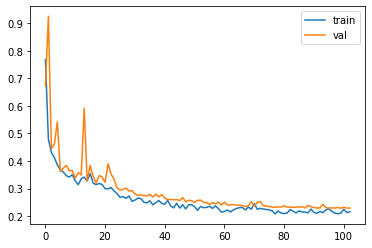

In [35]:
plt.plot(train_overall,label='train')
plt.plot(val_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

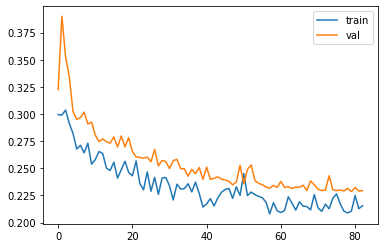

In [36]:
plt.plot(train_overall[20::],label='train')
plt.plot(val_overall[20::],label='val')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
plt.plot(train_overall[90:180],label='train')
plt.plot(val_overall[90:180],label='val')
plt.legend(['train', 'val'])
plt.show()

learning rate = 1e-3 and network was training for 90 epochs, with no scheduler<br>
Results:

In [31]:
for i,_ in enumerate(val_overall):
    val_overall[i] = val_overall[i].cpu().numpy()

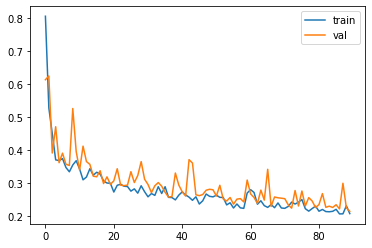

In [32]:
plt.plot(train_overall,label='train')
plt.plot(val_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

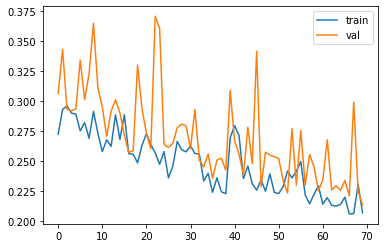

In [33]:
plt.plot(train_overall[20:90],label='train')
plt.plot(val_overall[20:90],label='val')
plt.legend(['train', 'val'])
plt.show()

learning rate = 1e-4 and network was training for 90 epochs, with no scheduler<br>
Results:

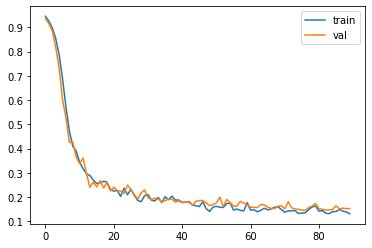

In [43]:
plt.plot(train_overall,label='train')
plt.plot(val_overall,label='val')
plt.legend(['train', 'val'])
plt.show()

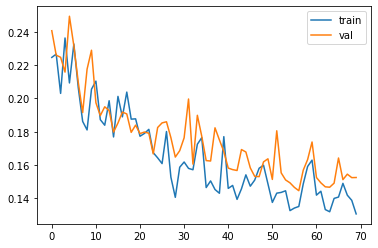

In [46]:
plt.plot(train_overall[20:90],label='train')
plt.plot(val_overall[20:90],label='val')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
def load_checkpoint(model, optimizer, losslogger, filename='model_ep36.pth'):
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['dice_score']
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(DEVICE)
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()